<a href="https://colab.research.google.com/github/adlerabf/Data_Science_Projects/blob/main/StockAnalysis_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means: Clusterização de perfil de risco de ações listadas na Bolsa.
---
Fonte dos nomes dos ativos: [Dados de Mercado](https://www.dadosdemercado.com.br/bolsa/acoes)

### Este projeto consiste em 3 passos:

1.   Usar a API yfinance da Yahoo Finance para coletar dados das ações
2.   Criar colunas de risco e volatiliade para medir o risco das ações
3.   Criar 3 clusters usando K-means para definir como Risco Baixo, Moderado e Alto



> Quanto mais volátil um ativo, maiores são suas tendências de dar altos retornos, como consequência, maior o risco de altos prejuízos. A intenção desse projeto é justamente identificar a relação risco x retorno das ações listadas na B3 de uma forma rápida e abrangente usando o modelo de Machine Learning K-means.






### Importação das bibliotecas necessárias

In [ ]:
# Bibliotecas para manipulação e coleta dos dados
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from pandas_datareader import data as pdr

# Bibliotecas gráficas
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# K-means
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# import pandas_datareader, sklearn, plotly
warnings.filterwarnings('ignore')
yf.pdr_override()

### Criando Dataframe com Tickers das ações

In [ ]:
df_stocks = pd.read_csv('/content/drive/MyDrive/acoes-listadas-b3.csv')

In [ ]:
df_stocks.head()

,Ticker,Nome,Negócios,Última (R$),Variação
0,MGLU3,Magazine Luiza,96.228.600,"1,57","+0,00%"
1,HAPV3,Hapvida,45.188.200,"3,88","+0,78%"
2,B3SA3,B3,42.955.100,"11,51","+1,05%"
3,BBDC4,Banco Bradesco,30.205.500,"13,77","-0,07%"
4,CPLE6,Copel,28.038.200,"9,55","-0,52%"


In [ ]:
df_tickers = df_stocks
df_tickers['Ticker'] = df_tickers['Ticker'] + '.SA'
df_tickers.head()

,Ticker,Nome,Negócios,Última (R$),Variação
0,MGLU3.SA,Magazine Luiza,96.228.600,"1,57","+0,00%"
1,HAPV3.SA,Hapvida,45.188.200,"3,88","+0,78%"
2,B3SA3.SA,B3,42.955.100,"11,51","+1,05%"
3,BBDC4.SA,Banco Bradesco,30.205.500,"13,77","-0,07%"
4,CPLE6.SA,Copel,28.038.200,"9,55","-0,52%"


#### Definindo o Dataset das Ações
> Combinando yfinance com o dataset com nome de ativos, usei a coluna Ticker como uma lista, aplicando um for para varrer essa lista e coletar os dados do Yahoo para cada ativo.

> Para definir a data de inicio e final, automatizei de usando a bibliteca datetime, para sempre que rodar a célula usar a data atual end date e considerar 5 anos para trás, para a start date.

In [ ]:
# Definindo o período desejado
start_date = (datetime.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d') # iniciar 5 anos atrás a partir de hoje
end_date = datetime.today().strftime('%Y-%m-%d') # selecionando a data de hoje

# Crie um DataFrame vazio para armazenar os resultados
lista_df = []
for ticker in df_tickers['Ticker']:
  try:
    df = pdr.get_data_yahoo(ticker,
                            start=start_date, end=end_date)
    # Cria nova coluina com o nome do ativo
    df['Ticker'] = ticker
    print(f'coletando o ativo {ticker}')
    # Adiciona os dados em uma lista
    lista_df.append(df)
  except e:
    print(f'Foi encontrado um erro no ativo: {ticker} - erro: {e}')

df_stocks = pd.concat(lista_df)

In [ ]:
df_stocks.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2019-05-09,5.637076,5.637076,5.433644,5.433644,5.403482,36980580,MGLU3.SA
2019-05-10,5.466672,5.516069,5.292176,5.451181,5.420923,30254350,MGLU3.SA
2019-05-13,5.392723,5.414645,5.261193,5.261778,5.232571,31995780,MGLU3.SA
2019-05-14,5.349172,5.407338,5.202736,5.210043,5.181123,34944920,MGLU3.SA
2019-05-15,5.151293,5.151293,5.018594,5.056591,5.028523,50922283,MGLU3.SA


In [ ]:
df_stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,461817.000000,461817.000000,461817.000000,461817.000000,461817.000000,4.618170e+05
mean,21.679864,22.009125,21.339629,21.680606,19.439449,3.274301e+06
std,39.810569,40.510974,39.108422,39.779297,37.254566,1.085181e+07
min,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000e+00
25%,6.650000,6.780000,6.510000,6.650000,5.960587,2.500000e+03
50%,12.680000,12.936084,12.430000,12.680000,11.379515,2.204000e+05
75%,24.510000,24.920000,24.120001,24.510000,21.600000,2.209105e+06
max,1025.463867,1037.195312,1007.751709,1032.824707,1032.824707,5.567312e+08


In [ ]:
(df_stocks.isnull()
          .mean()
          .sort_values(ascending=False)
          .round(4) *100)

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
Ticker       0.0
dtype: float64

In [ ]:
df_stocks.shape

(461817, 7)

In [ ]:
df_stocks.reset_index(inplace=True)

In [ ]:
df_stocks.set_index('Date', inplace=True)

In [ ]:
df_close = df_stocks[['Ticker', 'Adj Close']]
df_close.head()

,Ticker,Adj Close
Date,,
2019-05-09,MGLU3.SA,5.403482
2019-05-10,MGLU3.SA,5.420923
2019-05-13,MGLU3.SA,5.232571
2019-05-14,MGLU3.SA,5.181123
2019-05-15,MGLU3.SA,5.028523


In [ ]:
df_close.dtypes

Ticker        object
Adj Close    float64
dtype: object

### Criando as colunas Volatilidade e Retorno

In [ ]:
# Calcular variação percentual
df_close['pct_change'] = df_close.groupby('Ticker')['Adj Close'].pct_change()

# Calcular retorno anualisado para cada Ticker
returns = (df_close.groupby(['Ticker'])
                      .agg(returns = ('pct_change', 'mean')) * 252)

# Calcular volatilidade anualisada para cada Ticker
vol = (df_close.groupby('Ticker')
                      .agg(vol = ('pct_change', 'std')) * np.sqrt(252))


# Criando um dataframe contendo apenas os Tickers e Retorno e Volatilidade anuais
df_complete = pd.merge(returns, vol, how='inner', on='Ticker')


In [ ]:
df_complete.head()

,returns,vol
Ticker,,
AALR3.SA,0.084125,0.544635
ABCB4.SA,0.169771,0.345569
ABEV3.SA,0.012583,0.303062
AERI3.SA,-0.496460,0.640628
AESB3.SA,-0.131919,0.262293


In [ ]:
# Conferindo se há valores nulos
 (df_complete.isnull()
          .mean()
          .sort_values(ascending=False)
          .round(4) *100)

returns    0.0
vol        0.0
dtype: float64

In [ ]:
# Avaliando máximos e mínimos para checar a escalabilidade dos dados
df_complete.describe()

,returns,vol
count,400.000000,400.000000
mean,0.162764,0.569468
std,0.321739,0.305968
min,-1.052428,0.207923
25%,0.027779,0.394970
50%,0.161915,0.499499
75%,0.302868,0.655038
max,2.299713,3.711861


In [ ]:
df_complete.shape

(400, 2)

<Axes: xlabel='returns', ylabel='vol'>

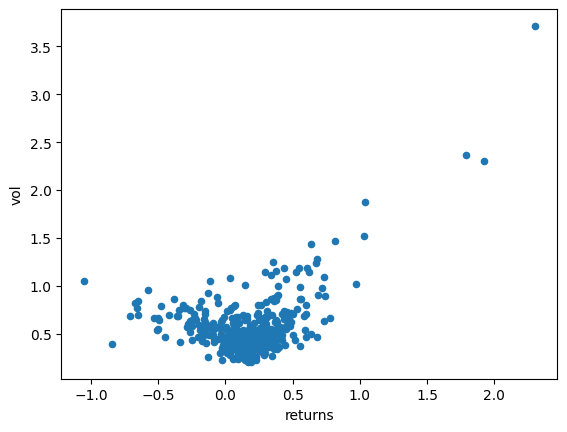

In [ ]:
# Analisando dispersão dos dados
df_complete.plot(kind='scatter', x='returns', y='vol')

In [ ]:
# Verificando a correlação
df_complete.corr()

,returns,vol
returns,1.000000,0.446895
vol,0.446895,1.000000


In [ ]:
df_complete.reset_index(inplace=True)

### Definindo cotovelo do WCSS

In [ ]:
# Função para calcular valores do WCSS
def calculate_wcss(stock_data):
  wcss = []
  for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state=0, init='k-means++')
    kmeans.fit(X=stock_data)
    wcss.append(kmeans.inertia_)
  return wcss

In [ ]:
# Seleciona os valores que serão utilizados na clusterização
stock_data = df_complete[['returns', 'vol']]

# Realiza o calculo WCSS
wcss_stocks = calculate_wcss(stock_data)

In [ ]:
# Visualizando os dados obtidos do WCSS
for i in range(len(wcss_stocks)):
  print(f'O cluster {i} possui o valor de WCSS de: {wcss_stocks[i]}')

O cluster 0 possui o valor de WCSS de: 78.6560089283002
O cluster 1 possui o valor de WCSS de: 50.06948230168253
O cluster 2 possui o valor de WCSS de: 34.455704372395225
O cluster 3 possui o valor de WCSS de: 20.612863696477866
O cluster 4 possui o valor de WCSS de: 16.061266293421085
O cluster 5 possui o valor de WCSS de: 13.201925944892672
O cluster 6 possui o valor de WCSS de: 11.509652849699037
O cluster 7 possui o valor de WCSS de: 10.03288679057139
O cluster 8 possui o valor de WCSS de: 8.822693056705745
O cluster 9 possui o valor de WCSS de: 7.850500506992219


#### Plotando o Cotovelo do WCSS

In [ ]:
plot_wcss = px.line( x = range(1,11),
                    y = wcss_stocks
                     )
fig = go.Figure(plot_wcss)

fig.update_layout(title = 'Calculando o WCSS',
                   xaxis_title ='Número de Clusters',
                   yaxis_title = 'Valor do WCSS',
                   template = 'plotly_white'
                   )
fig.show()

### Definindo os Clusters

In [ ]:
# Após analisar o plot do WCSS, é verificaso a possibilidade de até 5 clusters, contudo como o objtivo é separar as ações entre 3 classes
# Risco Baix, Risco Moderado e Risco Alto, serão usados apenas 3 clusers.
kmeans_stocks = KMeans(n_clusters=3,
                       random_state=0,
                       init='k-means++')
df_complete['cluster'] = kmeans_stocks.fit_predict(stock_data)

In [ ]:
df_complete.head(10)

,Ticker,returns,vol,cluster
0,AALR3.SA,0.084125,0.544635,2
1,ABCB4.SA,0.169771,0.345569,2
2,ABEV3.SA,0.012583,0.303062,2
3,AERI3.SA,-0.496460,0.640628,0
4,AESB3.SA,-0.131919,0.262293,0
5,AFLT3.SA,0.544761,1.182836,1
6,AGRO3.SA,0.248931,0.322122,2
7,AGXY3.SA,-0.498721,0.551914,0
8,AHEB3.SA,0.071569,0.541118,2
9,AHEB5.SA,-0.017030,0.345185,2


In [ ]:
# Adicinando coluna de risco e identificando cada risco
df_complete.loc[df_complete['cluster']==0,'risk'] = 'Low Risk'
df_complete.loc[df_complete['cluster']==1,'risk'] = 'High Risk'
df_complete.loc[df_complete['cluster']==2,'risk'] = 'Moderate Risk'

In [ ]:
df_complete.head(10)

,Ticker,returns,vol,cluster,risk,color
0,AALR3.SA,0.084125,0.544635,2,Moderate Risk,red
1,ABCB4.SA,0.169771,0.345569,2,Moderate Risk,red
2,ABEV3.SA,0.012583,0.303062,2,Moderate Risk,red
3,AERI3.SA,-0.496460,0.640628,0,Low Risk,green
4,AESB3.SA,-0.131919,0.262293,0,Low Risk,green
5,AFLT3.SA,0.544761,1.182836,1,High Risk,yellow
6,AGRO3.SA,0.248931,0.322122,2,Moderate Risk,red
7,AGXY3.SA,-0.498721,0.551914,0,Low Risk,green
8,AHEB3.SA,0.071569,0.541118,2,Moderate Risk,red
9,AHEB5.SA,-0.017030,0.345185,2,Moderate Risk,red


### Plotando os Clusters

In [ ]:
risk_colors = {
    'Low Risk': 'green',
    'Moderate Risk': 'yellow',
    'High Risk': 'red'
}

# Converter os valores da coluna 'risk' em cores correspondentes
df_complete['color'] = df_complete['risk'].map(risk_colors)


fig = make_subplots(rows = 1, cols = 1,
                    shared_xaxes = True,
                    vertical_spacing = 0.08)

fig.add_trace(go.Scatter( x = df_complete['vol'],
                          y = df_complete['returns'],
                          name = "", mode = 'markers',
                          text = df_complete['Ticker'],
                          marker = dict(size = 14, color = df_complete['color'])
                          )
              )
fig.update_layout( height = 800, width = 1000,
                  title_text = 'Anlálise de Clusters',
                   xaxis_title = "Volatilidade",
                   yaxis_title = "Retorno"
                   )

fig.show()